In [1]:
using Surrogates
using Plots
using Statistics
using Random
using DataFrames
using Distances
default()

In [2]:
function splitdf(df, pct)
           @assert 0 <= pct <= 1
           ids = collect(axes(df, 1))
           shuffle!(ids)
           sel = ids .<= nrow(df) .* pct
           return DataFrame(view(df, sel, :)), DataFrame(view(df, .!sel, :))
       end

splitdf (generic function with 1 method)

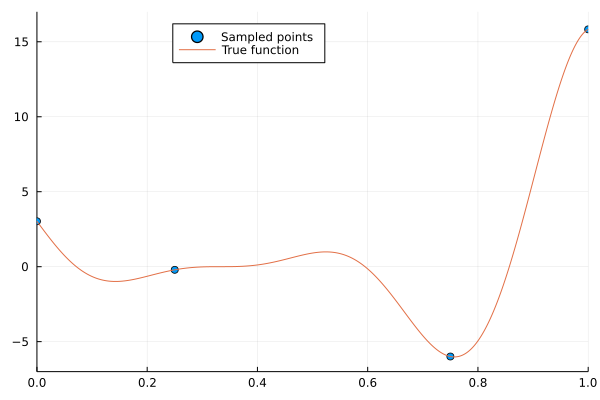

In [59]:
f(x) = (6 * x - 2)^2 * sin(12 * x - 4)

n_samples = 5
lower_bound = 0.0
upper_bound = 1.0

xs = lower_bound:0.001:upper_bound

x = sample(n_samples, lower_bound, upper_bound, SobolSample())
append!(x, lower_bound)
append!(x, upper_bound)
original_x = copy(x)
y = f.(x)
original_y = copy(y)

scatter(original_x, original_y, label="Sampled points", xlims=(lower_bound, upper_bound), ylims=(-7, 17))
plot!(xs, f.(xs), label="True function", legend=:top)

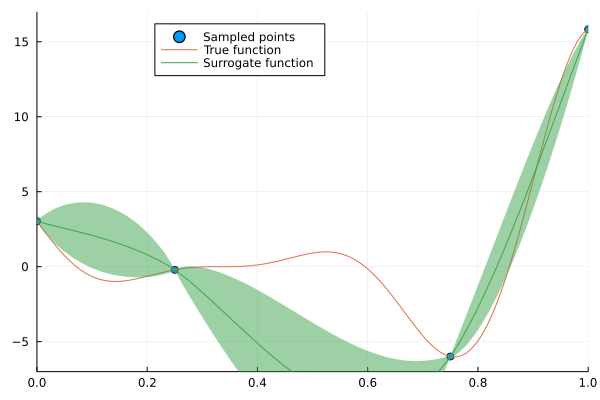

In [15]:
kriging_surrogate = Kriging(original_x, original_y, lower_bound, upper_bound, p=1.9);

plot(original_x, original_y, seriestype=:scatter, label="Sampled points", xlims=(lower_bound, upper_bound), ylims=(-7, 17), legend=:top)
plot!(xs, f.(xs), label="True function", legend=:top)
plot!(xs, kriging_surrogate.(xs), label="Surrogate function", ribbon=p->std_error_at_point(kriging_surrogate, p), legend=:top)

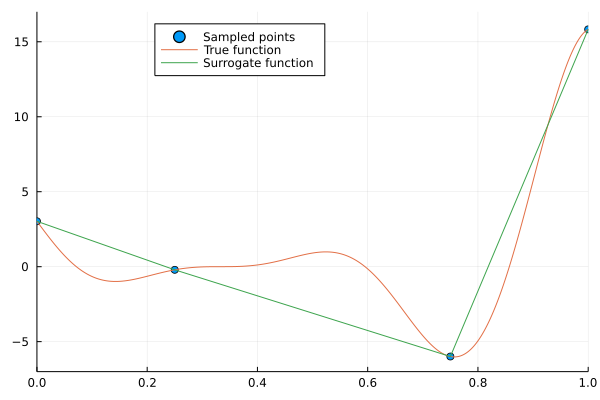

In [16]:
my_radial_basis = RadialBasis(original_x, original_y, lower_bound, upper_bound)
plot(original_x, original_y, seriestype=:scatter, label="Sampled points", xlims=(lower_bound, upper_bound), ylims=(-7, 17), legend=:top)
plot!(xs, f.(xs), label="True function", legend=:top)
plot!(xs, my_radial_basis.(xs), label="Surrogate function", legend=:top)

In [3]:
# Implementing diversity
function calculate_variance(x, models)
    predictions = []
        for model in models
            prediction = model(x)
            append!(predictions, prediction)
        end
    return var(predictions, corrected=false)
end

function diversity_metric(prev_x, new_x, models, lambda = 0.5)
    min_dist = Inf
    variance = calculate_variance(new_x, models)
    for point in prev_x
        new_dist = euclidean(point, new_x)
        if new_dist < min_dist
            min_dist = new_dist
        end
    end
    return (1 - lambda) * sqrt(variance) + lambda * min_dist
end

diversity_metric (generic function with 2 methods)

In [23]:
prev_points = copy(original_x)
y = copy(original_y)
sample_space = collect(xs)
for i in 1:5
    kriging_surrogate = Kriging(prev_points, y, lower_bound, upper_bound, p=1.9)
    my_radial_basis = RadialBasis(prev_points, y, lower_bound, upper_bound)
    x = []
    for i in 1:n_samples
        max_score = 0
        max_index = -1
        for j in 1:length(sample_space)
            score = diversity_metric(prev_points, sample_space[j], [my_radial_basis, kriging_surrogate], 0)
            if score > max_score
                max_score = score
                max_index = j
            end
        end
        append!(x, sample_space[max_index])
        deleteat!(sample_space, max_index)
    end
    prev_points = vcat(prev_points, x)
    y = f.(prev_points)
end

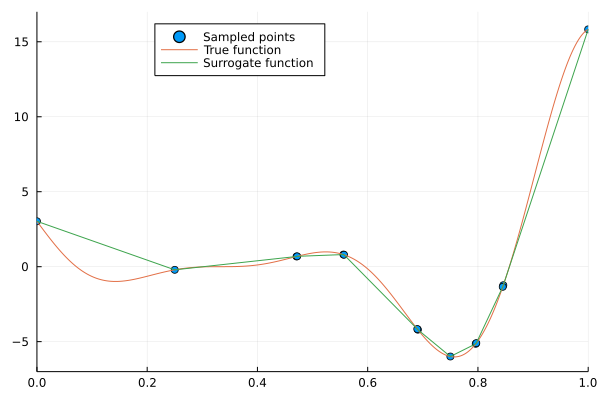

In [24]:
my_radial_basis = RadialBasis(prev_points, y, lower_bound, upper_bound)
plot(prev_points, y, seriestype=:scatter, label="Sampled points", xlims=(lower_bound, upper_bound), ylims=(-7, 17), legend=:top)
plot!(xs, f.(xs), label="True function", legend=:top)
plot!(xs, my_radial_basis.(xs), label="Surrogate function", legend=:top)

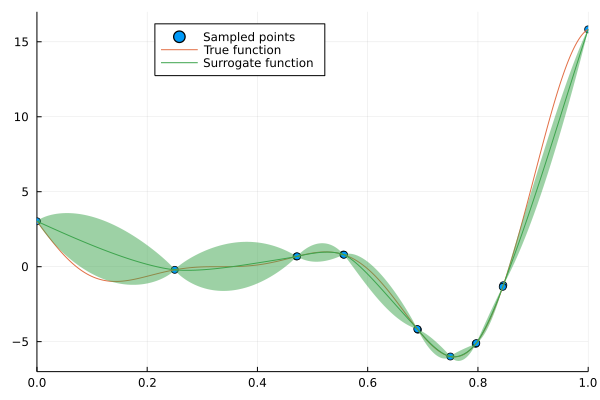

In [25]:
kriging_surrogate = Kriging(prev_points, y, lower_bound, upper_bound, p=1.9)
plot(prev_points, y, seriestype=:scatter, label="Sampled points", xlims=(lower_bound, upper_bound), ylims=(-7, 17), legend=:top)
plot!(xs, f.(xs), label="True function", legend=:top)
plot!(xs, kriging_surrogate.(xs), label="Surrogate function", ribbon=p->std_error_at_point(kriging_surrogate, p), legend=:top)

In [60]:
prev_points = copy(original_x)
y = copy(original_y)
sample_space = collect(xs)
for i in 1:10
    kriging_surrogate = Kriging(prev_points, y, lower_bound, upper_bound, p=1.9)
    my_radial_basis = RadialBasis(prev_points, y, lower_bound, upper_bound)
    x = []
    for i in 1:n_samples
        max_score = 0
        max_index = -1
        for j in 1:length(sample_space)
            score = diversity_metric(prev_points, sample_space[j], [my_radial_basis, kriging_surrogate], 0.98)
            if score > max_score
                max_score = score
                max_index = j
            end
        end
        append!(x, sample_space[max_index])
        deleteat!(sample_space, max_index)
    end
    prev_points = vcat(prev_points, x)
    y = f.(prev_points)
end

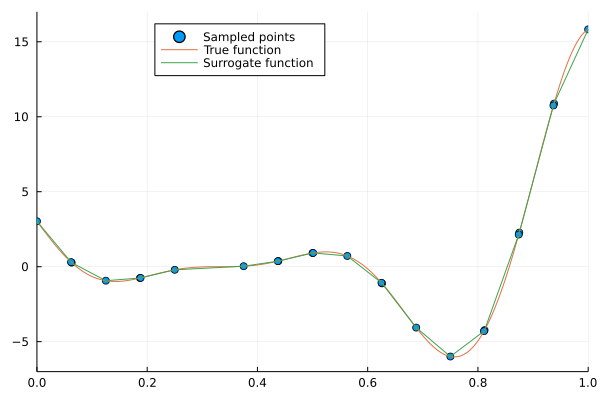

In [30]:
my_radial_basis = RadialBasis(prev_points, y, lower_bound, upper_bound)
plot(prev_points, y, seriestype=:scatter, label="Sampled points", xlims=(lower_bound, upper_bound), ylims=(-7, 17), legend=:top)
plot!(xs, f.(xs), label="True function", legend=:top)
plot!(xs, my_radial_basis.(xs), label="Surrogate function", legend=:top)

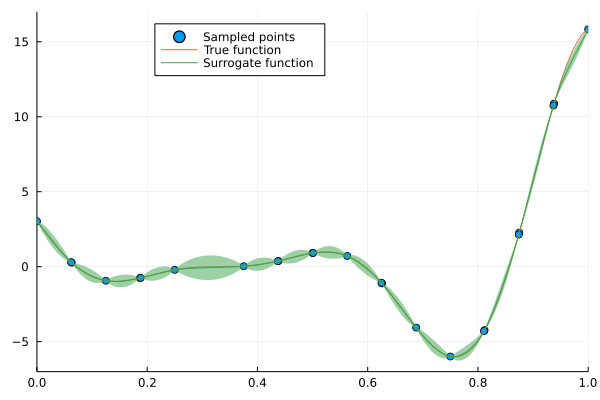

In [31]:
kriging_surrogate = Kriging(prev_points, y, lower_bound, upper_bound, p=1.9)
plot(prev_points, y, seriestype=:scatter, label="Sampled points", xlims=(lower_bound, upper_bound), ylims=(-7, 17), legend=:top)
plot!(xs, f.(xs), label="True function", legend=:top)
plot!(xs, kriging_surrogate.(xs), label="Surrogate function", ribbon=p->std_error_at_point(kriging_surrogate, p), legend=:top)

In [61]:
size(prev_points)

(24,)

In [4]:
function booth(x)
    x1=x[1]
    x2=x[2]
    term1 = (x1 + 2*x2 - 7)^2;
    term2 = (2*x1 + x2 - 5)^2;
    y = term1 + term2;
end

booth (generic function with 1 method)

In [7]:
n_samples = 20
lower_bound = [-5.0, 0.0]
upper_bound = [10.0, 15.0]

xys = sample(n_samples, lower_bound, upper_bound, SobolSample())
push!(xys, (-5, 0))
push!(xys, (-5, 15))
push!(xys, (10, 0))
push!(xys, (10, 15))
zs = booth.(xys);

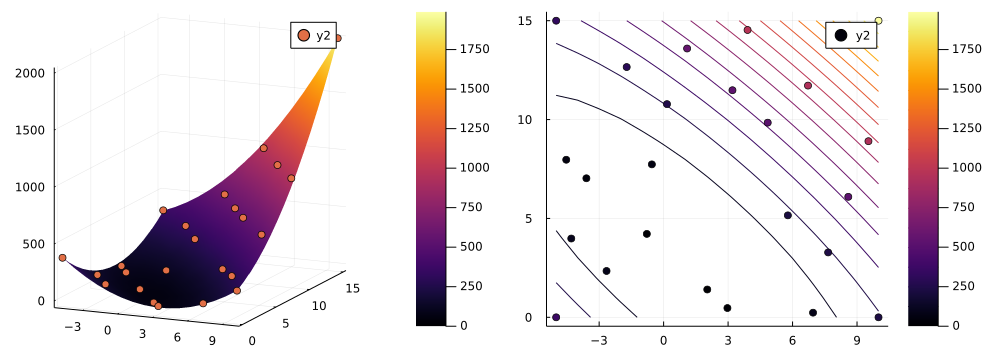

In [251]:
xs = [xy[1] for xy in xys]
ys = [xy[2] for xy in xys]
x = -5.0:10.0
y = 0.0:15.0
p1 = surface(x, y, (x, y) -> booth([x y])) # hide
scatter!(xs, ys, zs)
p2 = contour(x, y, (x, y) -> booth([x y]))
scatter!(xs, ys, marker_z=zs)
display(plot!(p1, p2, size=(1000,350), reuse=false))

In [238]:
radial_basis = RadialBasis(xys, zs,  lower_bound, upper_bound)

(::RadialBasis{Surrogates.var"#1#2", Int64, Vector{Tuple{Float64, Float64}}, Vector{Float64}, Vector{Float64}, Vector{Float64}, LinearAlgebra.Transpose{Float64, Vector{Float64}}, Float64, Bool}) (generic function with 1 method)

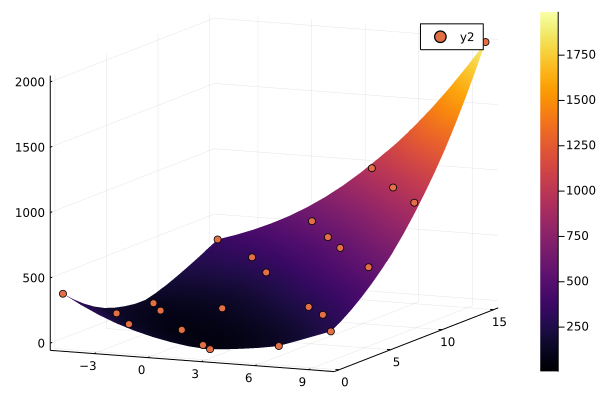

In [239]:
x = -5.0:10.0
y = 0.0:15.0
p1 = surface(x, y, (x, y) -> radial_basis([x y])) # hide
scatter!(xs, ys, zs)

In [18]:
function calculate_error(point, models, actual, mode="MSE")
    target = actual(point)
    errors = []
    for model in models
        prediction = model(point)
        append!(errors, abs(target - prediction))
    end
    if mode == "MSE"
        return mean(errors.^2)
    end
    if mode == "max"
        return maximum(errors)
    end
end

calculate_error (generic function with 2 methods)

In [91]:
total_samples = 1000
prev_points = copy(xys)
z = copy(zs)
sample_space = sample(total_samples, lower_bound, upper_bound, SobolSample())
test, orig_train = splitdf(DataFrame(sample_space), 0.2)
train = copy(orig_train)
error = Inf
while error > 100
    kriging_surrogate = Kriging(prev_points, z, lower_bound, upper_bound, p=[1.9, 1.9])
    my_radial_basis = RadialBasis(prev_points, z, lower_bound, upper_bound)
    x = []
    max_score = 0
    max_index = -1
    for j in 1:size(train)[1]
        point = (train[j, 1], train[j, 2])
        score = diversity_metric(prev_points, point, [my_radial_basis, kriging_surrogate], 0)
        if score > max_score
            max_score = score
            max_index = j
        end
    end
    append!(x, Vector([(train[max_index, 1], train[max_index, 2])]))
    deleteat!(train, max_index)
    prev_points = vcat(prev_points, x)
    z = booth.(prev_points)
    errors = []
    for k in 1:size(test)[1]
        point = (test[k, 1], test[k, 2])
        append!(errors, calculate_error(point, [my_radial_basis, kriging_surrogate], booth, "max"))
    end
    error = mean(errors)
    println(error)
end

168179.63729858247
256.7071594694117
252.93635598240184
246.83201659344155
245.34297615075243
249.43936409746087
237.47311850017127
242.09399243596945
241.4568637630266
245.84304079679177
249.7849746485087
240.1577260294073
227.12021370609853
216.18030417094832
201.93264387651433
190.49096033658117
177.82358582286116
177.70441720110236
172.656180488602
174.02345952797558
167.88420416544628
158.70087027412282
157.32873222020885
151.73416507598589
151.23002278752102
146.4229635791472
144.76543124982055
141.42557570790817
134.86615375124305
127.2369761013777
121.74939111929729
115.57935367148892
113.72569453552653
106.70569420013435
104.00112704783041
101.50894880750431
99.43886356745894


In [92]:
size(prev_points)

(58,)

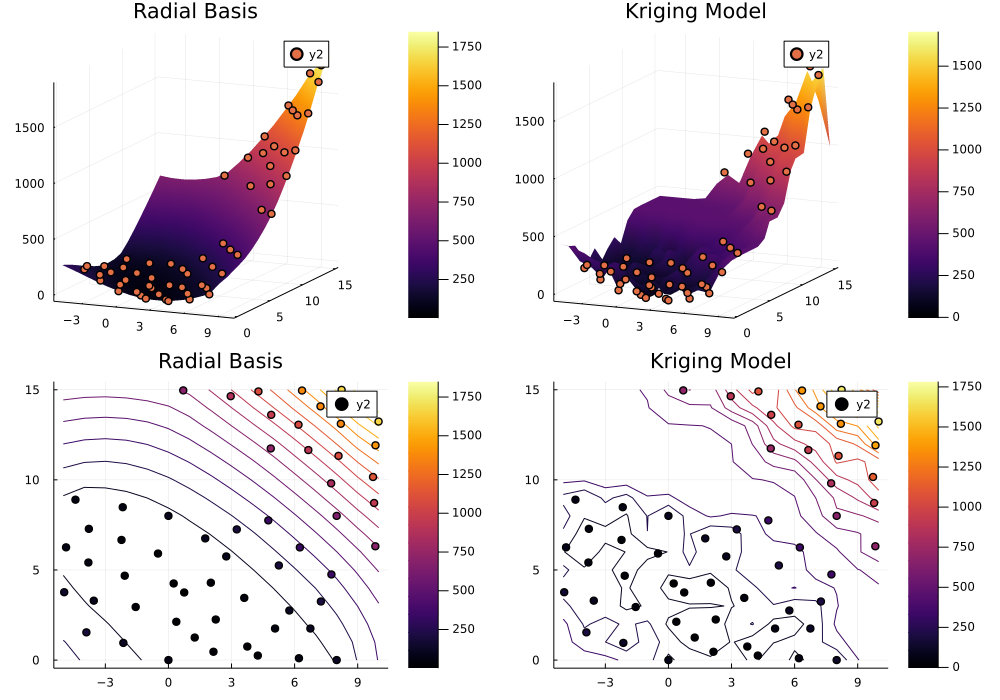

In [93]:
new_xs = [xy[1] for xy in prev_points]
new_ys = [xy[2] for xy in prev_points]
x = -5.0:10.0
y = 0.0:15.0
my_radial_basis = RadialBasis(prev_points, z, lower_bound, upper_bound)
my_kriging_model = Kriging(prev_points, z, lower_bound, upper_bound, p=[1.9, 1.9])
radial_zs = my_radial_basis.(prev_points)
p1 = surface(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, radial_zs)
kriging_zs = my_kriging_model.(prev_points)
p2 = surface(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, kriging_zs)
p3 = contour(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, marker_z=radial_zs)
p4 = contour(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, marker_z=kriging_zs)
display(plot!(p1, p2, p3, p4, size=(1000,700), reuse=false))

In [94]:
total_samples = 1000
prev_points = copy(xys)
z = copy(zs)
# sample_space = sample(total_samples, lower_bound, upper_bound, SobolSample())
# test, train = splitdf(DataFrame(sample_space), 0.2)
train = copy(orig_train)
error = Inf
while error > 100
    kriging_surrogate = Kriging(prev_points, z, lower_bound, upper_bound, p=[1.9, 1.9])
    my_radial_basis = RadialBasis(prev_points, z, lower_bound, upper_bound)
    x = []
    max_score = 0
    max_index = -1
    for j in 1:size(train)[1]
        point = (train[j, 1], train[j, 2])
        score = diversity_metric(prev_points, point, [my_radial_basis, kriging_surrogate], 1)
        if score > max_score
            max_score = score
            max_index = j
        end
    end
    append!(x, Vector([(train[max_index, 1], train[max_index, 2])]))
    deleteat!(train, max_index)
    prev_points = vcat(prev_points, x)
    z = booth.(prev_points)
    errors = []
    for k in 1:size(test)[1]
        point = (test[k, 1], test[k, 2])
        append!(errors, calculate_error(point, [my_radial_basis, kriging_surrogate], booth, "max"))
    end
    error = mean(errors)
end

In [95]:
size(prev_points)

(63,)

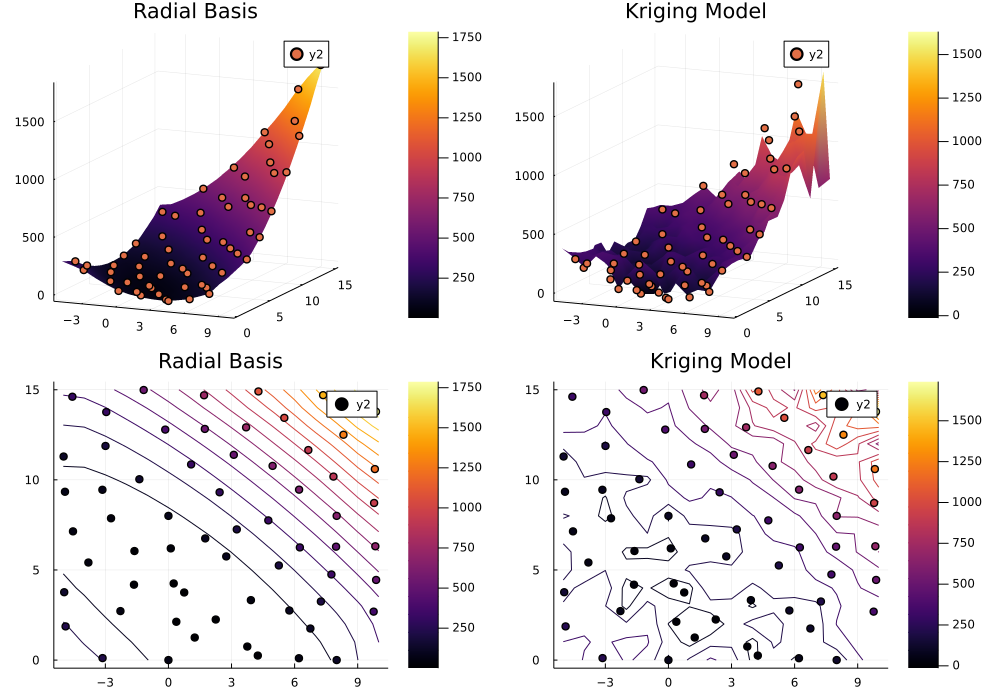

In [96]:
new_xs = [xy[1] for xy in prev_points]
new_ys = [xy[2] for xy in prev_points]
x = -5.0:10.0
y = 0.0:15.0
my_radial_basis = RadialBasis(prev_points, z, lower_bound, upper_bound)
my_kriging_model = Kriging(prev_points, z, lower_bound, upper_bound, p=[1.9, 1.9])
radial_zs = my_radial_basis.(prev_points)
p1 = surface(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, radial_zs)
kriging_zs = my_kriging_model.(prev_points)
p2 = surface(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, kriging_zs)
p3 = contour(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, marker_z=radial_zs)
p4 = contour(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, marker_z=kriging_zs)
display(plot!(p1, p2, p3, p4, size=(1000,700), reuse=false))

In [31]:
# Define the 2d Rosenbrock function
function Rosenbrock2d(x)
    x1 = x[1]
    x2 = x[2]
    return (1-x1)^2 + 100*(x2-x1^2)^2
end

Rosenbrock2d (generic function with 1 method)

In [32]:
n = 100     # Number of total sampling points
lb = [0.0,0.0]
ub = [8.0,8.0]
initial_n = 17      # Number of initial sampling points

17

In [34]:
xys = sample(initial_n,lb,ub,SobolSample());
push!(xys, (0.0, 0.0))
push!(xys, (0.0, 8.0))
push!(xys, (8.0, 0.0))
push!(xys, (8.0, 8.0))
zs = Rosenbrock2d.(xys);

In [97]:
total_samples = 1000
prev_points = copy(xys)
z = copy(zs)
sample_space = sample(total_samples, lb, ub, SobolSample())
test, orig_train = splitdf(DataFrame(sample_space), 0.2)
train = copy(orig_train)
error = Inf
while error > 10000
    kriging_surrogate = Kriging(prev_points, z, lb, ub, p=[1.9, 1.9])
    my_radial_basis = RadialBasis(prev_points, z, lb, ub)
    x = []
    max_score = 0
    max_index = -1
    for j in 1:size(train)[1]
        point = (train[j, 1], train[j, 2])
        score = diversity_metric(prev_points, point, [my_radial_basis, kriging_surrogate], 0)
        if score > max_score
            max_score = score
            max_index = j
        end
    end
    append!(x, Vector([(train[max_index, 1], train[max_index, 2])]))
    deleteat!(train, max_index)
    prev_points = vcat(prev_points, x)
    z = Rosenbrock2d.(prev_points)
    errors = []
    for k in 1:size(test)[1]
        point = (test[k, 1], test[k, 2])
        append!(errors, calculate_error(point, [my_radial_basis, kriging_surrogate], Rosenbrock2d, "max"))
    end
    error = mean(errors)
    println(error)
end

37265.14256780172
34830.218230570754
35081.18575088965
36056.27257124524
31099.09871449061
28488.624699565327
27317.41492606039
23518.414811893264
20142.26112434813
18609.5983729673
16451.624012745375
15487.085238308071
14251.8304297633
12472.114391913437
11735.189026183607
10806.152103465785
9948.402734000272


In [98]:
println(size(prev_points))

(38,)


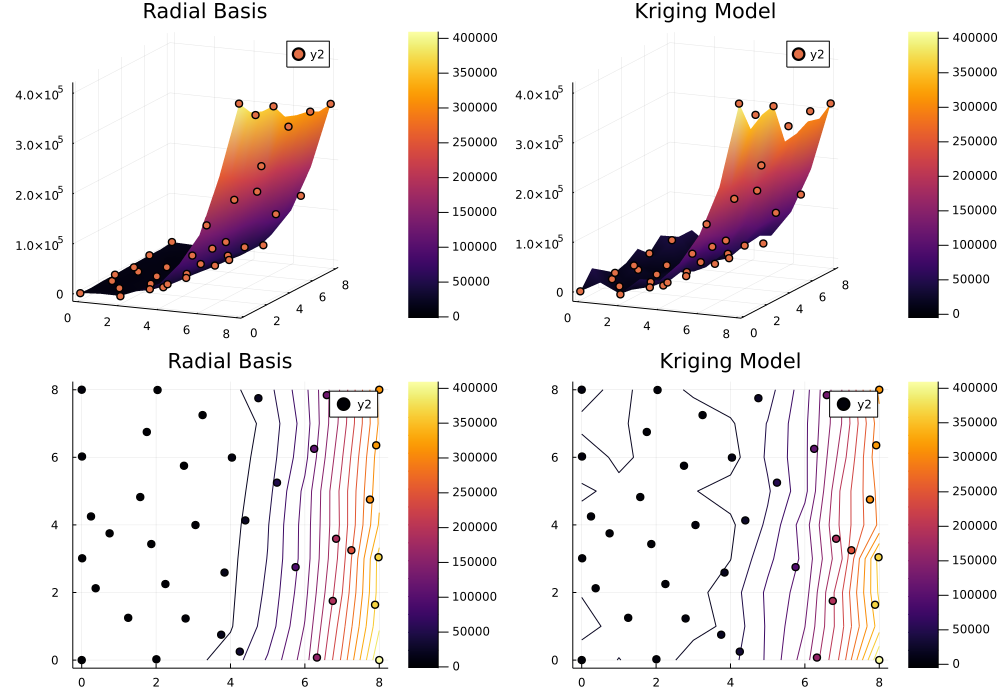

In [99]:
new_xs = [xy[1] for xy in prev_points]
new_ys = [xy[2] for xy in prev_points]
x = 0.0:8.0
y = 0.0:8.0
my_radial_basis = RadialBasis(prev_points, z, lb, ub)
my_kriging_model = Kriging(prev_points, z, lb, ub, p=[1.9, 1.9])
radial_zs = my_radial_basis.(prev_points)
p1 = surface(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, radial_zs)
kriging_zs = my_kriging_model.(prev_points)
p2 = surface(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, kriging_zs)
p3 = contour(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, marker_z=radial_zs)
p4 = contour(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, marker_z=kriging_zs)
display(plot!(p1, p2, p3, p4, size=(1000,700), reuse=false))

In [101]:
total_samples = 1000
prev_points = copy(xys)
z = copy(zs)
# sample_space = sample(total_samples, lb, ub, SobolSample())
# test, train = splitdf(DataFrame(sample_space), 0.2)
train = copy(orig_train)
error = Inf
while error > 10000
    kriging_surrogate = Kriging(prev_points, z, lb, ub, p=[1.9, 1.9])
    my_radial_basis = RadialBasis(prev_points, z, lb, ub)
    x = []
    max_score = 0
    max_index = -1
    for j in 1:size(train)[1]
        point = (train[j, 1], train[j, 2])
        score = diversity_metric(prev_points, point, [my_radial_basis, kriging_surrogate], 1)
        if score > max_score
            max_score = score
            max_index = j
        end
    end
    append!(x, Vector([(train[max_index, 1], train[max_index, 2])]))
    deleteat!(train, max_index)
    prev_points = vcat(prev_points, x)
    z = Rosenbrock2d.(prev_points)
    errors = []
    for k in 1:size(test)[1]
        point = (test[k, 1], test[k, 2])
        append!(errors, calculate_error(point, [my_radial_basis, kriging_surrogate], Rosenbrock2d, "max"))
    end
    error = mean(errors)
end

In [102]:
println(size(prev_points))

(42,)


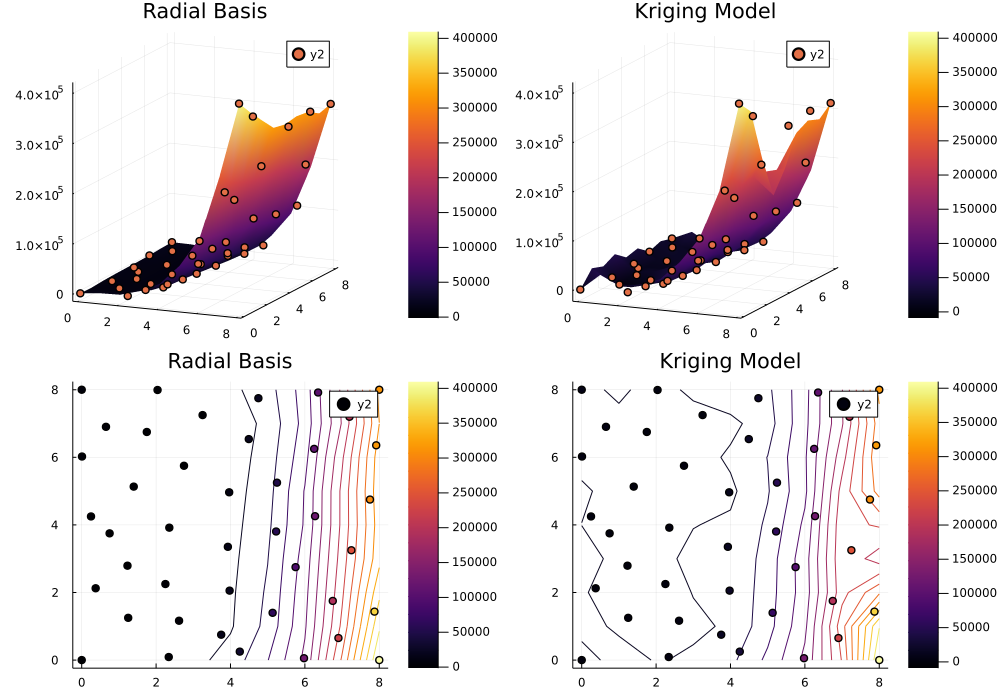

In [103]:
new_xs = [xy[1] for xy in prev_points]
new_ys = [xy[2] for xy in prev_points]
x = 0.0:8.0
y = 0.0:8.0
my_radial_basis = RadialBasis(prev_points, z, lb, ub)
my_kriging_model = Kriging(prev_points, z, lb, ub, p=[1.9, 1.9])
radial_zs = my_radial_basis.(prev_points)
p1 = surface(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, radial_zs)
kriging_zs = my_kriging_model.(prev_points)
p2 = surface(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, kriging_zs)
p3 = contour(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, marker_z=radial_zs)
p4 = contour(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, marker_z=kriging_zs)
display(plot!(p1, p2, p3, p4, size=(1000,700), reuse=false))

In [104]:
total_samples = 1000
prev_points = copy(xys)
z = copy(zs)
sample_space = sample(total_samples, lb, ub, SobolSample())
test, orig_train = splitdf(DataFrame(sample_space), 0.2)
train = copy(orig_train)
error = Inf
while error > 10 ^ 7
    kriging_surrogate = Kriging(prev_points, z, lb, ub, p=[1.9, 1.9])
    my_radial_basis = RadialBasis(prev_points, z, lb, ub)
    x = []
    max_score = 0
    max_index = -1
    for j in 1:size(train)[1]
        point = (train[j, 1], train[j, 2])
        score = diversity_metric(prev_points, point, [my_radial_basis, kriging_surrogate], 0)
        if score > max_score
            max_score = score
            max_index = j
        end
    end
    append!(x, Vector([(train[max_index, 1], train[max_index, 2])]))
    deleteat!(train, max_index)
    prev_points = vcat(prev_points, x)
    z = Rosenbrock2d.(prev_points)
    errors = []
    for k in 1:size(test)[1]
        point = (test[k, 1], test[k, 2])
        append!(errors, calculate_error(point, [my_radial_basis, kriging_surrogate], Rosenbrock2d))
    end
    error = mean(errors)
    println(error)
end

1.2510257109024825e9
1.2184401212969275e9
1.0764619609084265e9
7.441885231507204e8
5.883365621111122e8
5.302688056658519e8
5.2361302158858496e8
4.4843840294515306e8
3.697663424388441e8
2.7499647731978816e8
2.901938886372718e8
2.2707874355438533e8
2.003888058257513e8
1.7990794242974824e8
1.710024383569536e8
1.616076610975296e8
1.5980023098749974e8
1.4893167401905057e8
1.3349619285675408e8
1.4341047308641303e8
1.1978405522609542e8
9.251237093823193e7
8.167551235522504e7
7.704166538992481e7
7.104535275060609e7
6.790446284327453e7
6.165298195542128e7
6.741697650623901e7
5.8241730830153115e7
5.57411534988823e7
5.0353084300508745e7
4.472993923342124e7
4.454794999688159e7
4.22687058331538e7
3.618820455897496e7
3.5207989605020665e7
3.548522453552305e7
3.458295261760172e7
3.286462667461542e7
3.2138268931857582e7
3.2369544115251765e7
3.1071915766071316e7
3.0661687449045613e7
2.951205972459381e7
2.5541194725692067e7
1.748034767659552e7
1.6387901551451527e7
1.612443393539362e7
1.5370986780264607e7

In [105]:
println(size(prev_points))

(82,)


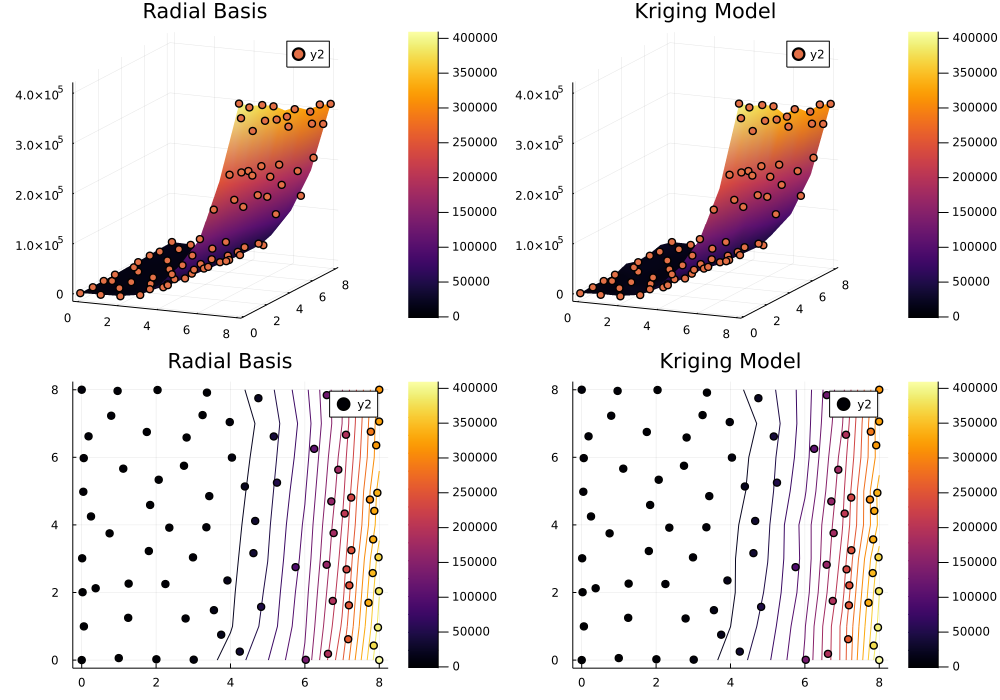

In [106]:
new_xs = [xy[1] for xy in prev_points]
new_ys = [xy[2] for xy in prev_points]
x = 0.0:8.0
y = 0.0:8.0
my_radial_basis = RadialBasis(prev_points, z, lb, ub)
my_kriging_model = Kriging(prev_points, z, lb, ub, p=[1.9, 1.9])
radial_zs = my_radial_basis.(prev_points)
p1 = surface(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, radial_zs)
kriging_zs = my_kriging_model.(prev_points)
p2 = surface(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, kriging_zs)
p3 = contour(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, marker_z=radial_zs)
p4 = contour(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, marker_z=kriging_zs)
display(plot!(p1, p2, p3, p4, size=(1000,700), reuse=false))

In [107]:
total_samples = 1000
prev_points = copy(xys)
z = copy(zs)
# sample_space = sample(total_samples, lb, ub, SobolSample())
# test, train = splitdf(DataFrame(sample_space), 0.2)
train = copy(orig_train)
error = Inf
while error > 10 ^ 7
    kriging_surrogate = Kriging(prev_points, z, lb, ub, p=[1.9, 1.9])
    my_radial_basis = RadialBasis(prev_points, z, lb, ub)
    x = []
    max_score = 0
    max_index = -1
    for j in 1:size(train)[1]
        point = (train[j, 1], train[j, 2])
        score = diversity_metric(prev_points, point, [my_radial_basis, kriging_surrogate], 1)
        if score > max_score
            max_score = score
            max_index = j
        end
    end
    append!(x, Vector([(train[max_index, 1], train[max_index, 2])]))
    deleteat!(train, max_index)
    prev_points = vcat(prev_points, x)
    z = Rosenbrock2d.(prev_points)
    errors = []
    for k in 1:size(test)[1]
        point = (test[k, 1], test[k, 2])
        append!(errors, calculate_error(point, [my_radial_basis, kriging_surrogate], Rosenbrock2d))
    end
    error = mean(errors)
end

In [108]:
println(size(prev_points))

(164,)


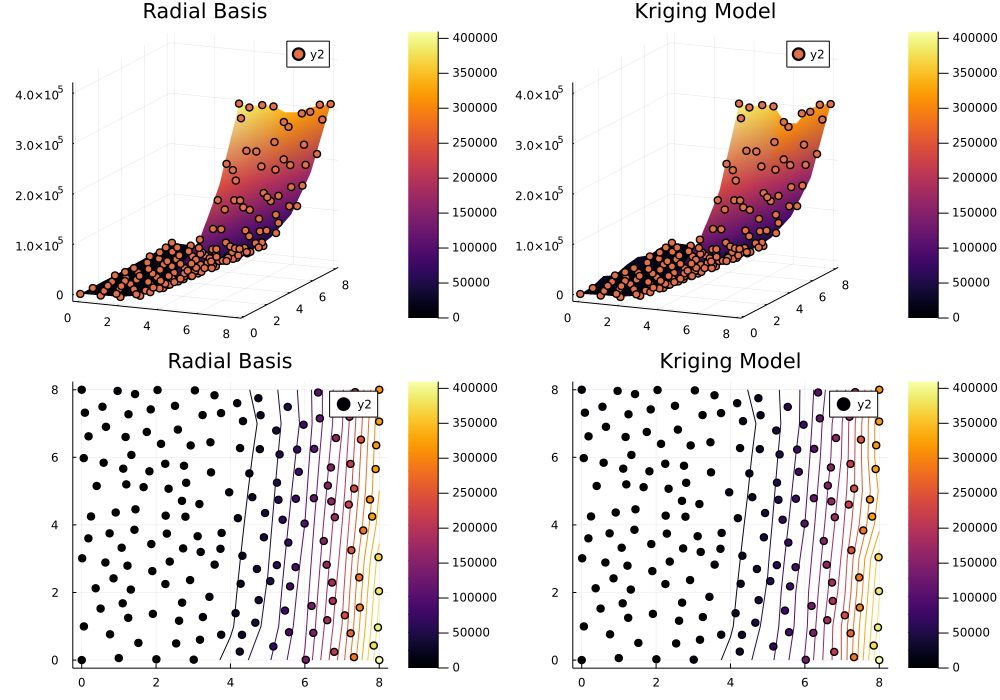

In [109]:
new_xs = [xy[1] for xy in prev_points]
new_ys = [xy[2] for xy in prev_points]
x = 0.0:8.0
y = 0.0:8.0
my_radial_basis = RadialBasis(prev_points, z, lb, ub)
my_kriging_model = Kriging(prev_points, z, lb, ub, p=[1.9, 1.9])
radial_zs = my_radial_basis.(prev_points)
p1 = surface(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, radial_zs)
kriging_zs = my_kriging_model.(prev_points)
p2 = surface(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, kriging_zs)
p3 = contour(x, y, (x, y) -> my_radial_basis([x y]), title="Radial Basis")
scatter!(new_xs, new_ys, marker_z=radial_zs)
p4 = contour(x, y, (x, y) -> my_kriging_model([x y]), title="Kriging Model")
scatter!(new_xs, new_ys, marker_z=kriging_zs)
display(plot!(p1, p2, p3, p4, size=(1000,700), reuse=false))